## Pivot Points trading

We would try pivot points trading. The following formulas would be used

 * P = (H+L+C)/3
 * R1 = 2 * P - L
 * S1 = 2 * P - H
 * R2 = P + (H - L)
 * S2 = P - (H - L)
 * R3 = R1 + (H- L)
 * S3 = S1 - (H - L)

In [64]:
# Import the necessary libraries
import pandas as pd
import seaborn as sns
sns.set()
from fastbt.datasource import DataSource
from fastbt.rapid import *

In [65]:
# Loading data
df = pd.read_csv('data/data.csv', parse_dates=['timestamp'])

In [66]:
# Let's look at the first 5 rows
df.head()

,symbol,series,open,high,low,close,last,prevclose,qty,volume,timestamp,totaltrades,isin_code,prevdayret,prevhigh,prevlow
0,INFY,EQ,1037.7,1044.5,1030.00,1033.55,1032.15,1042.05,2715670,2.814046e+09,2018-01-01,65839,INE009A01021,NaN,NaN,NaN
1,IOC,EQ,390.0,392.5,388.50,389.95,390.50,388.55,2218462,8.658350e+08,2018-01-01,24346,INE242A01010,NaN,NaN,NaN
2,IBULHSGFIN,EQ,1196.6,1243.9,1194.85,1218.15,1217.50,1196.60,1323659,1.625793e+09,2018-01-01,26037,INE148I01020,NaN,NaN,NaN
3,HINDUNILVR,EQ,1367.0,1367.0,1340.05,1344.50,1345.00,1367.85,746852,1.007039e+09,2018-01-01,16383,INE030A01027,NaN,NaN,NaN
4,HINDPETRO,EQ,419.0,421.2,412.40,413.75,414.80,418.60,2087052,8.674081e+08,2018-01-01,15704,INE094A01015,NaN,NaN,NaN


Let's add all the formulas above.

I use the eval function to use the formula directly. The `eval` function is used to evaluate expression as formulas. So instead of writing
```python
    df['p'] = (df['high'] + df['low'] + df['close'])/3
```
you could used
```python
    df['p'] = df.eval('(high+low+close)/3')
```

In [67]:
# Now add the necessary formulas

df['_p'] = df.eval('(high+low+close)/3')
df['_r1'] = df.eval('2*_p-low')
df['_s1'] = df.eval('2*_p-high')
df['_r2'] = df.eval('_p+(high-low)')
df['_s2'] = df.eval('_p-(high-low)')
df['_r3'] = df.eval('_r1+(high-low)')
df['_s3'] = df.eval('_s1-(high-low)')



The pivot points we calculated are based on the data for the end of the data. We need this data for the next day to make trades. So, I would just be lagging the data for these columns for one day.

*The columns would now be named without underscore.*

In [68]:
cols = ['_p', '_r1', '_r2', '_r3', '_s1', '_s2', '_s3']
ds = DataSource(df)
for col in cols:
    ds.add_lag(on=col, period=1, col_name=col[1:])

# Let's add the daily return 
ds.add_formula('(prevclose/close)-1', col_name='ret')
ds.add_lag(on='ret', period=1, col_name='retprev');

Let's take a look at the correlation to see whether these points have any effect. Looks nothing interesting

In [69]:
ds.data.corr()['ret'].sort_values()

volume        -0.014000
prevdayret    -0.013819
last          -0.009858
close         -0.009842
_s3           -0.009368
_s1           -0.009336
_r1           -0.009304
_r3           -0.009273
_s2           -0.008818
_p            -0.008799
_r2           -0.008778
low           -0.008281
high          -0.008273
open          -0.006469
s3            -0.003573
s2            -0.003486
s1            -0.003433
prevlow       -0.003401
p             -0.003350
r1            -0.003300
prevhigh      -0.003269
r2            -0.003220
r3            -0.003172
prevclose     -0.002847
totaltrades    0.003841
qty            0.013411
retprev        0.015864
ret            1.000000
Name: ret, dtype: float64

Let's create the parameters for backtest

We would place buy orders when the price hits the first support and hold till the end of the day. 

We would select 3 orders every day sorted according to price (this is *dumb* but we need some security selection)

In [70]:
# Backtest parameters
# 

params = {
    'data': ds.data.dropna(),
    'limit': 3,
    'sort_by': 'price',
    'order': 'B',
    'price': 's1-0.05', # Buy only when price falls below support
    'stop_loss': 100, # No stop loss,
    'commission': 0.05
}

In [71]:
results = backtest(**params)

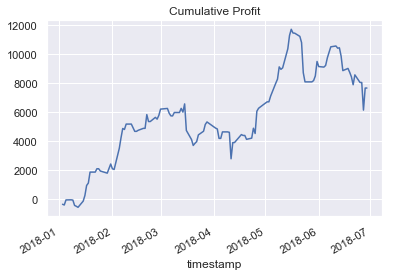

In [72]:
results.groupby('timestamp').profit.sum().cumsum().plot(
    title='Cumulative Profit')

Let's try selling orders at first resistance and holding them till the end of the day

In [73]:
params = {
    'data': ds.data.dropna(),
    'limit': 3,
    'sort_by': 'price',
    'order': 'S',
    'price': 'r1+0.05', # Buy only when price goes above resistance
    'stop_loss': 100, # No stop loss,
    'commission': 0.05
}


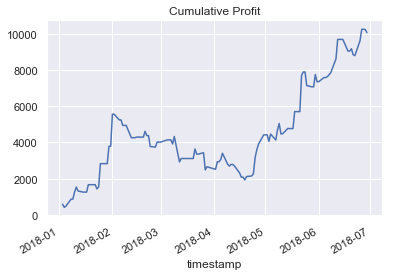

In [74]:
results2 = backtest(**params)
results2.groupby('timestamp').profit.sum().cumsum().plot(
    title='Cumulative Profit')

Wow, we got profit in both these cases.

Let's try out a different sort mode, on previous day return

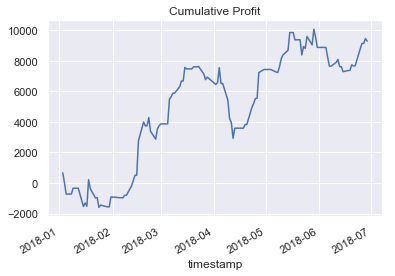

In [75]:
params.update({'sort_by': 'retprev'})
backtest(**params).groupby('timestamp').profit.sum().cumsum().plot(
    title='Cumulative Profit')

We see no big difference in results.

Let's merge the results and see the trades.

In [76]:
final = pd.concat([results, results2], sort=False).reset_index(drop=True)

# Delete unwanted columns
for col in final.columns:
    if col.startswith('_'):
        del final[col]

pd.options.display.max_columns = 50
final.sort_values(by='timestamp').set_index('timestamp').head()

,symbol,series,open,high,low,close,last,prevclose,qty,volume,totaltrades,isin_code,prevdayret,prevhigh,prevlow,p,r1,r2,r3,s1,s2,s3,ret,retprev,price,stop_loss,buy,sell,cnt,profit,commission,slippage,net_profit
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-03,NTPC,EQ,179.5,180.30,176.75,177.05,177.00,178.90,188.0,1.841344e+09,46065,INE733E01010,0.013311,179.25,176.55,178.233333,179.916667,180.933333,182.616667,177.216667,175.533333,174.516667,0.010449,-0.013136,177.15,0.0,177.15,177.05,3,-18.80,33.294800,0.0,-52.094800
2018-01-03,NTPC,EQ,179.5,180.30,176.75,177.05,177.00,178.90,185.0,1.841344e+09,46065,INE733E01010,0.013311,179.25,176.55,178.233333,179.916667,180.933333,182.616667,177.216667,175.533333,174.516667,0.010449,-0.013136,179.95,359.9,177.05,179.95,3,536.50,33.022500,0.0,503.477500
2018-01-03,POWERGRID,EQ,201.5,202.45,200.60,201.65,202.10,200.75,165.0,9.281992e+08,68699,INE752E01010,0.002747,201.80,199.30,200.616667,201.933333,203.116667,204.433333,199.433333,198.116667,196.933333,-0.004463,-0.002740,202.00,404.0,201.65,202.00,3,57.75,33.301125,0.0,24.448875
2018-01-03,ONGC,EQ,197.4,197.40,193.00,193.45,193.65,196.85,168.0,1.562229e+09,58365,INE213A01029,0.023395,197.50,195.00,196.450000,197.900000,198.950000,200.400000,195.400000,193.950000,192.900000,0.017576,-0.022860,197.95,395.9,193.45,193.45,3,0.00,32.499600,0.0,-32.499600
2018-01-03,ONGC,EQ,197.4,197.40,193.00,193.45,193.65,196.85,171.0,1.562229e+09,58365,INE213A01029,0.023395,197.50,195.00,196.450000,197.900000,198.950000,200.400000,195.400000,193.950000,192.900000,0.017576,-0.022860,195.35,0.0,195.35,193.45,3,-324.90,33.242400,0.0,-358.142400


## Is this really profitable?

Let's check out the metrics

In [77]:
metrics(final, capital=20000)

{'profit': 17732.749999999818,
 'commission': 24367.078475000002,
 'slippage': 0.0,
 'net_profit': -6634.328475000182,
 'high': 4833.046449999952,
 'low': -8416.673300000095,
 'returns': -0.3317164237500091}

## Caveats

Though it seems that this might result in a loss, we still have a decent return before profits. Important pointers

* I included commission even for orders not place; reducing them would reduce the total expenses
* **Slippage not included** in the calculation. I expect the excess commission paid would set off the slippage. But this is pure intuition; better **test it out**
* The universe is NIFTY 50; trying it out on other universe or highly volatile stocks would give better results
* Change prices to different levels and the pivot points calculation method
* Add an estimator to sort results, so that you can determine whether its better to enter into support or resistance for a particular stock.
* Try changing the other parameters

